# Welcome to Full Stack Machine Learning's Week 3 Project!

Welcome aboard the bustling streets of New York City, where every second counts and efficiency is paramount. As a key member of the data science team for YellowCab, your mission, should you choose to accept, is to leverage machine learning to predict taxi fares for rides throughout the city. With one of the most comprehensive datasets at your disposal, you'll explore the intriguing world of regression models in a real-world setting.

## Your Journey with YellowCab

YellowCab is a titan in NYC's transport industry, transporting millions of riders every year. You're at the forefront of enhancing their digital experience. By creating an accurate fare prediction model, you can transform YellowCab's operations, enhancing user experience by providing accurate fare estimates prior to booking.

Remember, you're not just a data scientist - you're a trailblazer guiding YellowCab towards a data-centric future. By the end of this project, you'll have hands-on experience in building, evaluating, and deploying machine learning models for real-world applications. Are you ready to drive YellowCab's digital transformation?

## Task 1: Diving into the Data - Exploratory Data Analysis

Your first pit stop involves understanding your dataset - a rich collection of taxi trip records from yellow and green taxis, and For-Hire Vehicle (FHV) trips in NYC, accessible [here](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet). 

Devote about an hour to acquaint yourself with the dataset's structure and quirks.

In [1]:
# imports
from metaflow import S3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# configuration
YELLOW = "#FFBC00"
GREEN = "#37795D"
PURPLE = "#5460C0"
BACKGROUND = "#F4EBE6"
colors = [GREEN, PURPLE]
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.facecolor": BACKGROUND,
    "figure.facecolor": BACKGROUND,
    "figure.figsize": (8, 8),
}
sns_palette = sns.color_palette(colors, len(colors))
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
# Open a context manager to download data from the cloud.
s3 = S3(s3root="s3://outerbounds-datasets/taxi")

# Use Metaflow S3 client to get the latest file.
# This file is being updated every hour, simulating the changing, drifting, and sometimes broken nature of production data streams.
obj = s3.get("latest.parquet")
# The goal is to write a flow that builds and cross-validates a model to predicts the total fare of each taxi rid (row) in the dataset.
# Since the data is changing, Task 2 and 3 asks you to deploy a flow to production via Argo workflows, so your workflow can run automatically when this file changes in S3.

# Load the contents of the parquet file in memory.
df = pd.read_parquet(obj.path)

s3.close()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057339 entries, 0 to 3020012
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1057339 non-null  int64         
 1   tpep_pickup_datetime   1057339 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1057339 non-null  datetime64[ns]
 3   passenger_count        1032381 non-null  float64       
 4   trip_distance          1053203 non-null  float64       
 5   RatecodeID             1032381 non-null  float64       
 6   store_and_fwd_flag     1032381 non-null  object        
 7   PULocationID           1057339 non-null  int64         
 8   DOLocationID           1057339 non-null  int64         
 9   payment_type           1057339 non-null  int64         
 10  fare_amount            1057339 non-null  float64       
 11  extra                  1057339 non-null  float64       
 12  mta_tax                10573

In [4]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
count,1.057339e+06,1.032381e+06,1.053203e+06,1.032381e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.057339e+06,1.032381e+06,1.032381e+06,1.057339e+06
mean,1.730837e+00,1.382532e+00,3.954053e+00,1.556745e+00,1.661215e+02,1.639721e+02,1.212691e+00,1.887293e+01,1.514414e+00,4.876704e-01,3.338440e+00,5.561147e-01,9.811624e-01,2.750436e+01,2.249455e+00,1.203577e-01,1.467343e+02
std,4.435253e-01,9.158092e-01,2.412910e+02,6.838550e+00,6.421223e+01,7.016836e+01,5.428431e-01,1.863804e+01,1.806824e+00,1.134469e-01,3.905307e+00,2.086829e+00,1.864937e-01,2.303128e+01,8.042509e-01,3.744801e-01,7.816175e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-5.800000e+02,-7.500000e+00,-5.000000e-01,-3.393000e+01,-6.500000e+01,-1.000000e+00,-5.835000e+02,-2.500000e+00,-1.250000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.080000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,7.500000e-01,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00,8.500000e+01
50%,2.000000e+00,1.000000e+00,1.810000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.660000e+00,0.000000e+00,1.000000e+00,2.015000e+01,2.500000e+00,0.000000e+00,1.440000e+02
75%,2.000000e+00,1.000000e+00,3.500000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.140000e+00,0.000000e+00,1.000000e+00,2.904000e+01,2.500000e+00,0.000000e+00,2.130000e+02
max,2.000000e+00,8.000000e+00,2.259874e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,9.990000e+02,1.125000e+01,5.316000e+01,2.115000e+02,8.655000e+01,1.000000e+00,1.000000e+03,2.500000e+00,1.250000e+00,2.790000e+02


In [5]:
obviously_bad_data_filters = [
    df.fare_amount > 0,  # fare_amount in US Dollars
    df.trip_distance <= 100,  # trip_distance in miles
    df.trip_distance > 0,
    df.passenger_count > 0
]

for f in obviously_bad_data_filters:
    df = df[f]

/tmp/ipykernel_9192/3853395331.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[f]


In [6]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
count,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000,989465.000000
mean,1.745213,1.407601,3.601554,1.495194,166.282610,164.089154,1.217835,19.032112,1.550277,0.497292,3.366723,0.565622,0.998383,27.824192,2.300529,0.123507,147.605849
std,0.435742,0.907182,4.649301,6.488185,63.937985,70.112645,0.460860,17.840494,1.796069,0.065279,3.864358,2.074612,0.033726,22.197635,0.677414,0.373002,77.652318
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.100000,1.000000,132.000000,114.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,15.400000,2.500000,0.000000,86.000000
50%,2.000000,1.000000,1.840000,1.000000,162.000000,162.000000,1.000000,12.800000,1.000000,0.500000,2.690000,0.000000,1.000000,20.150000,2.500000,0.000000,145.000000
75%,2.000000,1.000000,3.530000,1.000000,234.000000,234.000000,1.000000,20.500000,2.500000,0.500000,4.140000,0.000000,1.000000,29.000000,2.500000,0.000000,213.000000
max,2.000000,6.000000,93.050000,99.000000,265.000000,265.000000,4.000000,580.000000,11.250000,53.160000,211.500000,86.550000,1.000000,583.500000,2.500000,1.250000,279.000000


In [7]:
df["RatecodeID"].value_counts()

1.0     935164
2.0      42759
99.0      4351
3.0       3222
5.0       2469
4.0       1500
Name: RatecodeID, dtype: int64

In [8]:
 df["PULocationID"].value_counts()

132    60144
237    48059
236    46819
161    42739
186    36719
       ...  
199        1
221        1
109        1
184        1
204        1
Name: PULocationID, Length: 249, dtype: int64

In [9]:
df["DOLocationID"].value_counts()

236    49455
237    43120
161    38875
141    29121
239    28965
       ...  
84         7
204        6
59         4
111        4
99         1
Name: DOLocationID, Length: 260, dtype: int64

In [10]:
df["payment_type"].value_counts()

1    788832
2    191602
4      5876
3      3155
Name: payment_type, dtype: int64

In [11]:
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
0,2,2023-10-31 02:32:10,2023-10-31 02:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.00,0.0,1.0,14.30,2.5,0.0,0
1,2,2023-10-31 02:55:08,2023-10-31 03:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.00,0.0,1.0,16.90,2.5,0.0,1
2,2,2023-10-31 02:25:04,2023-10-31 02:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.0,0.5,15.00,0.0,1.0,34.90,2.5,0.0,0
4,2,2023-10-31 02:10:29,2023-10-31 02:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.0,0
5,2,2023-10-31 02:50:34,2023-10-31 03:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.0,0.5,10.00,0.0,1.0,27.80,2.5,0.0,1


In [31]:
df_sorted = df.sort_values(["tpep_pickup_datetime"])

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
1034355,1,2023-11-11 16:55:20,2023-11-11 16:59:09,2.0,0.80,1.0,N,239,238,2,6.5,2.5,0.5,0.00,0.0,1.0,10.50,2.5,0.0,278
1031942,2,2023-11-11 16:56:14,2023-11-11 16:58:48,1.0,0.55,1.0,N,236,236,2,5.1,0.0,0.5,0.00,0.0,1.0,9.10,2.5,0.0,278
1031986,2,2023-11-11 16:56:29,2023-11-11 16:59:48,1.0,0.50,1.0,N,237,237,1,5.8,0.0,0.5,1.96,0.0,1.0,11.76,2.5,0.0,278
1030533,1,2023-11-11 16:56:33,2023-11-11 16:59:28,1.0,0.90,1.0,N,263,236,1,5.8,2.5,0.5,1.00,0.0,1.0,10.80,2.5,0.0,278
1040583,2,2023-11-11 16:56:34,2023-11-11 16:58:07,1.0,0.20,1.0,N,236,263,1,3.7,0.0,0.5,0.00,0.0,1.0,7.70,2.5,0.0,278


Text(0, 0.5, 'Fare')

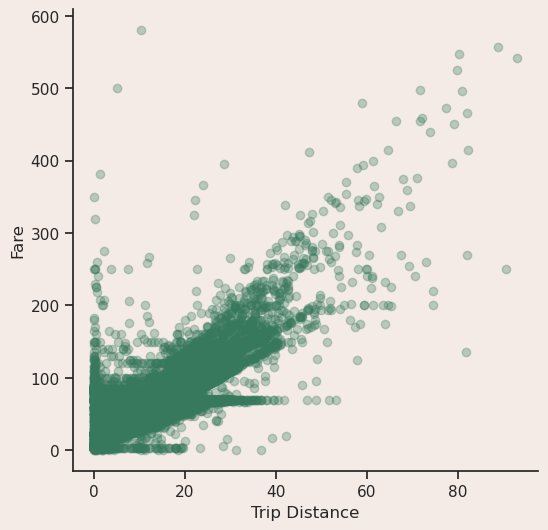

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(df.trip_distance, df.fare_amount, color=GREEN, alpha=0.3)
ax.set_xlabel("Trip Distance")
ax.set_ylabel("Fare")

## Task 2: Harnessing the Power of the Cloud - Argo Workflow Deployment
With a solid understanding of your dataset, it's time to deploy a workflow to Argo Workflows. A key aspect of this task is the @trigger decorator. This decorator configures Argo to listen for updates to the latest.parquet file (mentioned in Task 1) and trigger the flow when an S3 event is emitted. This is a practical introduction to event-driven machine learning, a vital part of real-world ML systems.

And here's the exciting part: This new capability to trigger workflows based on events has been recently introduced by Metaflow, marking a significant advancement in building scalable, real-world ML systems. Read more about this on [Metaflow's blog](https://outerbounds.com/blog/metaflow-event-triggering/).


Notice the use of the `@trigger` flow-level decorator.
In this flow, this is telling Argo to listen for events named `s3`, and to trigger a run of the flow when the S3 event is emitted. 
The S3 event your sandbox is listening for are the updates to the `latest.parquet` file mentioned in the comments in [Task 1](#task-1-eda). 

In [32]:
%%writefile ../flows/cloud/event_triggered_linear_regression.py
from metaflow import FlowSpec, step, card, conda_base, current, Parameter, Flow, trigger
from metaflow.cards import Markdown, Table, Image, Artifact

URL = "https://outerbounds-datasets.s3.us-west-2.amazonaws.com/taxi/latest.parquet"
DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"
FEATURES = ["tpep_pickup_datetime",
          "passenger_count",
          "RatecodeID",
          "trip_distance"]
TARGET = ["total_amount"]

@trigger(events=["s3"])
@conda_base(
    libraries={
        "pandas": "1.4.2",
        "pyarrow": "11.0.0",
        "scikit-learn": "1.1.2",
        "dirty_cat":"0.4.1"
    }
)
class TaxiFarePrediction(FlowSpec):
    data_url = Parameter("data_url", default=URL)

    @step
    def start(self):
        import pandas as pd
        
        self.data = pd.read_parquet(self.data_url).sort_values(["tpep_pickup_datetime"])
        self.X = self.data[FEATURES]
        self.y = self.data[TARGET]
        
        self.next(self.vectorizer_assembly)
        
    @step
    def vectorizer_assembly(self):
        from dirty_cat import TableVectorizer
        from sklearn.preprocessing import OrdinalEncoder


        low_card_encoder = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
        self.vectorizer = TableVectorizer(impute_missing="force",
                                          low_card_cat_transformer=low_card_encoder)

        self.next(self.regressor_model)

    @step
    def regressor_model(self):
        from sklearn.ensemble import HistGradientBoostingRegressor
        from sklearn.pipeline import make_pipeline

        self.model = make_pipeline(self.vectorizer,HistGradientBoostingRegressor())

        self.next(self.validate)

    def gather_sibling_flow_run_results(self):
        # storage to populate and feed to a Table in a Metaflow card
        rows = []

        # loop through runs of this flow
        for run in Flow(self.__class__.__name__):
            if run.id != current.run_id:
                if run.successful:
                    icon = "✅"
                    msg = "OK"
                    score = str(run.data.scores.mean())
                else:
                    icon = "❌"
                    msg = "Error"
                    score = "NA"
                    for step in run:
                        for task in step:
                            if not task.successful:
                                msg = task.stderr
                row = [
                    Markdown(icon),
                    Artifact(run.id),
                    Artifact(run.created_at.strftime(DATETIME_FORMAT)),
                    Artifact(score),
                    Markdown(msg),
                ]
                rows.append(row)
            else:
                rows.append(
                    [
                        Markdown("✅"),
                        Artifact(run.id),
                        Artifact(run.created_at.strftime(DATETIME_FORMAT)),
                        Artifact(str(self.scores.mean())),
                        Markdown("This run..."),
                    ]
                )
        return rows

    @card(type="corise")
    @step
    def validate(self):
        from sklearn.model_selection import cross_val_score
        from sklearn.model_selection import TimeSeriesSplit
        
        tscv = TimeSeriesSplit()
        self.scores = cross_val_score(self.model, self.X, self.y, cv=tscv)
        current.card.append(Markdown("# Taxi Fare Prediction Results"))
        current.card.append(
            Table(
                self.gather_sibling_flow_run_results(),
                headers=["Pass/fail", "Run ID", "Created At", "R^2 score", "Stderr"],
            )
        )
        self.next(self.end)

    @step
    def end(self):
        print(f"R2 Score:{self.scores.mean():0.2f}")
        print("Success!")


if __name__ == "__main__":
    TaxiFarePrediction()

Overwriting ../flows/cloud/event_triggered_linear_regression.py


### Run the Flow

In [33]:
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda run

Metaflow 2.9.7.2+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Bootstrapping conda environment...(this could take a few minutes)
2023-11-11 18:05:43.659 Workflow starting (run-id 105), see it in the UI at https://ui-pw-1668674295.outerbounds.dev/TaxiFarePrediction/105
2023-11-11 18:05:44.900 [105/start/570 (pid 12029)] Task is starting.
2023-11-11 18:05:56.019 [105/start/570 (pid 12029)] Task finished successfully.
2023-11-11 18:05:57.218 [105/vectorizer_assembly/571 (pid 12133)] Task is starting.
2023-11-11 18:06:00.689 [105/vectorizer_assembly/571 (pid 12133)] Task finished successfully.
2023-11-11 18:06:01.876 [105/regressor_model/572 (pid 12181)] Task is starting.
2023-11-11 18:06:05.445 [105/regressor_model/572 (pid 12181)] Task finished successfully.
2023-11-11 18:06:06.615 [105/validate/573 (pid 12229)] Task is starting.
2023-11-11 18:06:36.710 [105/validate/573 (pid 12229)] Task fini

## Task 3: Taking Flight - Promoting Your Workflow to Production

After thorough testing and validation, it's time to elevate your workflow to the production environment. Your model will then be running in the cloud, independent of manual triggers, serving predictions to improve YellowCab's service. To help you with this task, refer to [Metaflow's Argo documentation](https://docs.metaflow.org/production/scheduling-metaflow-flows/scheduling-with-argo-workflows).

### Deploying the workflow to Argo

In [28]:
# NOTE: If you run from this from the terminal you may need to adjust the path to the flow file, depending on where you saved it - what comes after %%writefile? 
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda --with retry argo-workflows create 

Metaflow 2.9.7.2+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Deploying taxifareprediction to Argo Workflows...
It seems this is the first time you are deploying taxifareprediction to Argo Workflows.

A new production token generated.

The namespace of this production flow is
    production:taxifareprediction-0-ouyj
To analyze results of this production flow add this line in your notebooks:
    namespace("production:taxifareprediction-0-ouyj")
If you want to authorize other people to deploy new versions of this flow to Argo Workflows, they need to call
    argo-workflows create --authorize taxifareprediction-0-ouyj
when deploying this flow to Argo Workflows for the first time.
See "Organizing Results" at https://docs.metaflow.org/ for more information about production tokens.

Bootstrapping conda environment...(this could take a few minutes)
Workflow taxifareprediction for flow TaxiFarePred

Now, go to the Argo deployment attached to your sandbox by finding your ID from the URL in your browser.

Your sandbox has a unique ID, visible in the URL with this pattern.
```
https://vs-<YOUR ID>.outerbounds.dev/<DELETE EVERYTHING AFTER THIS>
```

Remove the `vs` part in front, and everything after `.dev`, then navigate to your sandboxes Argo deployment at:
```
https://argo-<YOUR ID>.outerbounds.dev/
```

Navigating to the "Workflow Templates" section of the Argo UI, you should find your workflow has been deployed:

<img src="../img/argo-workflow-template.png" width="1200px">

### Manually trigger the workflow

In [29]:
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda argo-workflows trigger

Metaflow 2.9.7.2+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Workflow taxifareprediction triggered on Argo Workflows (run-id argo-taxifareprediction-9fjff).
See the run in the UI at https://ui-pw-1668674295.outerbounds.dev/TaxiFarePrediction/argo-taxifareprediction-9fjff


After triggering the worfklow, return to your Argo dashboard and navigate to the `Workflows` section to see your flow executing:

<img src="../img/argo-workflow.png" width="1200px">

### How is the flow "automatically" triggered? 

In the previous section, you manually triggered the deployed flow using a Metaflow command. 
So how will it run without that manual trigger in production? 

1. There is a script running in the background in your sandbox that looks at the `latest.parquet` file in S3 and emits an `S3` when it has changed since the last `TaxiFarePrediction` flow run was created. As mentioned earlier, the file is being updated every hour, time shifting the [NYC taxi data stream from January 2023](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet).
2. When the events are emitted, the same thing happens as the command you ran in [the previous section](#manually-trigger-the-workflow).

## Task 4: Navigating Challenges - Handling Failures (Bonus Task)

Real-world data is unpredictable. 

To prepare for this, we'll introduce a common scenario by intentionally corrupting some training data. Your task is to make your TaxiFarePrediction flow robust against such data quality issues.

Can you,
1. Figure out what is happening in the new data that is causing an error?
2. Add a few lines of code to your `TaxiFarePrediction` flow's `start` step that will make your flow robust to this kind of data quality issue?
3. How would you refactor the `TaxiFarePrediction` to use the decorators you learned in this week's lesson, such as `@catch`, `@retry`, etc.? 

(Optional) TODO: Write a report of your findings to these questions. 

(Optional) TODO: Update your production deployment of `TaxiFarePrediction` with the new approach(es).